# Neural FCA Big HW


## Import all necessary libraries

Importing all the necessary libraries to get started

In [1]:
import torch
from IPython.display import clear_output

print(torch.__version__)

2.5.1+cu121


In [2]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray==2.7.5

In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-k0jns2ng
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-k0jns2ng
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit bd5ae45c74a3fbb6b6ff818476f7651d84313d2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Now we import the dataset according to the instructions that were on the site: https://archive.ics.uci.edu/dataset/184/acute%2Binflammations, and also connect the Google drive for the neural fca file in the .py format

In [4]:
pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
acute_inflammations = fetch_ucirepo(id=184)

# data (as pandas dataframes)
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# metadata
print(acute_inflammations.metadata)

# variable information
print(acute_inflammations.variables)


{'uci_id': 184, 'name': 'Acute Inflammations', 'repository_url': 'https://archive.ics.uci.edu/dataset/184/acute+inflammations', 'data_url': 'https://archive.ics.uci.edu/static/public/184/data.csv', 'abstract': 'The data was created by a medical expert as a data set to test the expert system, \nwhich will perform the presumptive diagnosis of two diseases of the urinary system.\n', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 120, 'num_features': 6, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['bladder-inflammation', 'nephritis'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2003, 'last_updated': 'Tue Apr 16 2024', 'dataset_doi': '10.24432/C5V59S', 'creators': ['Jacek Czerniak'], 'intro_paper': {'ID': 477, 'type': 'NATIVE', 'title': 'Application of rough sets in the presumptive diagnosis of urinary system diseases', 'authors'

In [6]:
X

,temperature,nausea,lumbar-pain,urine-pushing,micturition-pains,burning-urethra
0,35.5,no,yes,no,no,no
1,35.9,no,no,yes,yes,yes
2,35.9,no,yes,no,no,no
3,36.0,no,no,yes,yes,yes
4,36.0,no,yes,no,no,no
...,...,...,...,...,...,...
115,41.4,no,yes,yes,no,yes
116,41.5,no,no,no,no,no
117,41.5,yes,yes,no,yes,no
118,41.5,no,yes,yes,no,yes


In [7]:
y

,bladder-inflammation,nephritis
0,no,no
1,yes,no
2,no,no
3,yes,no
4,no,no
...,...,...
115,no,yes
116,no,no
117,no,yes
118,no,yes


The final dataset is ready

In [8]:
df = X.join(y)

Import all necessary libraries

In [9]:
# importing all libraries
import torch
import numpy as np
import pandas as pd

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['figure.facecolor'] = (1,1,1,1)

Now let's connect the file itself to work with neural fca.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import sys
sys.path.append('/content/drive/MyDrive')

In [12]:
import neural_lib62 as nl

## Dataset

Consider the dataset. Let's check for zero values and build descriptive statistics of the dataset

In [13]:
df.head(5)

,temperature,nausea,lumbar-pain,urine-pushing,micturition-pains,burning-urethra,bladder-inflammation,nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [14]:
df.shape

(120, 8)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature           120 non-null    float64
 1   nausea                120 non-null    object 
 2   lumbar-pain           120 non-null    object 
 3   urine-pushing         120 non-null    object 
 4   micturition-pains     120 non-null    object 
 5   burning-urethra       120 non-null    object 
 6   bladder-inflammation  120 non-null    object 
 7   nephritis             120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


## Binarization strategy

Let's look to dataset's attributes and their values:
1. Temperature of patient - integer value;
2. Occurrence of nausea - "yes" or "no";
3. Lumbar pain - "yes" or "no";
4. Urine pushing (continuous need for urination) - "yes" or "no";
5. Micturition pains - "yes" or "no";
6. Burning of urethra, itch, swelling of urethra outlet - "yes" or "no".

Our targets for binary classification:
1. Inflammation of urinary bladder - "yes" or "no";
2. Nephritis of renal pelvis origin - "yes" or "no".

In this work I will stop on one target, namely "Inflammation of urinary bladder" or "Cystitis" in medical terms.

Primarily let's rename our attributes for better usability.

In [16]:
df.rename(columns = {
    "temperature": "t",
    "nausea":'s1',
    "lumbar-pain":'s2',
    "urine-pushing":'s3',
    "micturition-pains":'s4',
    "burning-urethra":'s5',
    "bladder-inflammation":'diag1',
    "nephritis":'diag2',
    }, inplace = True)
df.head()

,t,s1,s2,s3,s4,s5,diag1,diag2
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


This code performs data analysis related to patient temperatures and visualizes the temperature distribution using the Seaborn library.

Min patient temperature in data = 35.5
Max patient temperature in data = 41.5



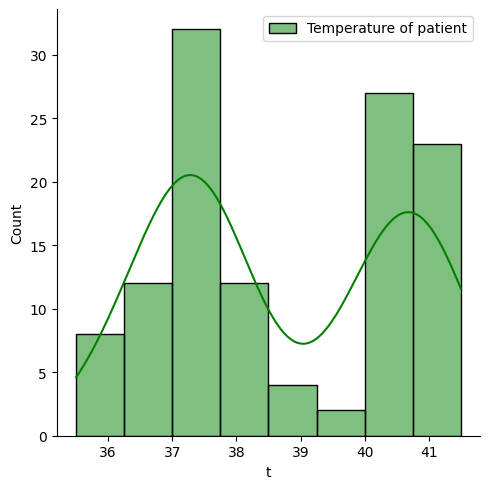

In [17]:
# Find the minimum temperature among all values in the 't' column of DataFrame 'df'
min_temp = min(df['t'])

# Find the maximum temperature among all values in the 't' column of DataFrame 'df'
max_temp = max(df['t'])

# Print the minimum and maximum temperature to the console
print(f"Min patient temperature in data = {min_temp}\nMax patient temperature in data = {max_temp}\n")

# Create a distribution plot of patient temperatures
sns.displot(df['t'], color='Green', label="Temperature of patient", kde=True)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

We see that mostly near 37-37.5 and 40-41.5 degrees Celsius.

I am going to binarize this attribute based on the source [[1]](https://www.tuasaude.com/en/how-to-tell-if-you-have-a-fever/):
* false if temperature $\in[35.5,37.2]$;
* true if temperature $\in[37.3,41.5]$.



In [18]:
cat_temp = pd.cut(df['t'], [min_temp, 37.3, max_temp+1], right=False, labels=[False, True])
cat_temp

,t
0,False
1,False
2,False
3,False
4,False
...,...
115,True
116,True
117,True
118,True


Now, it is time to concatenate our binary table of attributes.

In [19]:
df_cat = df[['s1', 's2', 's3', 's4', 's5']].join([cat_temp])
df_bin = df_cat.replace(['yes', 'no'], [True, False])
df_bin = df_bin.astype('bool')

<ipython-input-19-4d5baf8fc5eb>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bin = df_cat.replace(['yes', 'no'], [True, False])


Let's also make beauitifull numeration for data.

In [20]:
s = pd.Series([f'case {i}' for i in range(df.shape[0])])
df_bin = df_bin.set_index([s])
df_bin.head()

,s1,s2,s3,s4,s5,t
case 0,False,True,False,False,False,False
case 1,False,False,True,True,True,False
case 2,False,True,False,False,False,False
case 3,False,False,True,True,True,False
case 4,False,True,False,False,False,False


Let's make a target feature table.

In [21]:
df_target1 = df["diag1"]
df_target1 = df_target1.replace(['yes', 'no'], [True, False])
df_target1

<ipython-input-21-56cac1f041ad>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_target1 = df_target1.replace(['yes', 'no'], [True, False])


,diag1
0,False
1,True
2,False
3,True
4,False
...,...
115,False
116,False
117,False
118,False


And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_bin, df_target1, test_size=0.2, random_state=59, shuffle=True)

## Prediction quality measure

I prefer to use the **F1 score** because it maintains a balance between precision and recall for the classifier and it gives a better measure of the incorrectly classified cases than the accuracy metric.

## Fitting and testing the network on the task

Firstly, let's put binarized data in FormalContext and compute monotone ConceptLattice.

In [23]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 6 attributes, 301 connections)
        |s1|s2|s3|s4|s5|t|
case 10 |  |  | X| X| X| |
case 96 |  | X| X|  | X|X|
case 100|  | X| X|  | X|X|
case 12 |  | X|  |  |  | |
case 112| X| X|  | X|  |X|
case 43 |  |  | X|  |  |X|
case 63 |  | X| X|  | X|X|
case 22 |  | X|  |  |  | |
case 62 |  | X| X|  | X|X|
case 24 |  |  | X| X| X| |
..........................
..........................
case 95 | X| X|  | X|  |X|
case 0  |  | X|  |  |  | |
case 57 |  | X|  |  |  |X|
case 53 |  |  | X| X| X|X|
case 79 | X| X| X| X| X|X|
case 107|  |  |  |  |  |X|
case 23 |  |  | X| X| X| |
case 77 |  | X| X|  | X|X|
case 44 |  |  | X|  |  |X|
case 49 |  |  | X| X|  |X|

In [24]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

20

So, we have 20 formal concepts. Let's compute F1 score for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

In [25]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    new_measures = c.measures.set('f1_score', f1_score(y_train, y_preds))
    c.measures = new_measures

Select indices of the best concepts from the lattice. Here and further I take the minimum possible count of best concepts.

In [26]:
concepts_count = 7
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [27]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visualizer for the architecture.

In [28]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

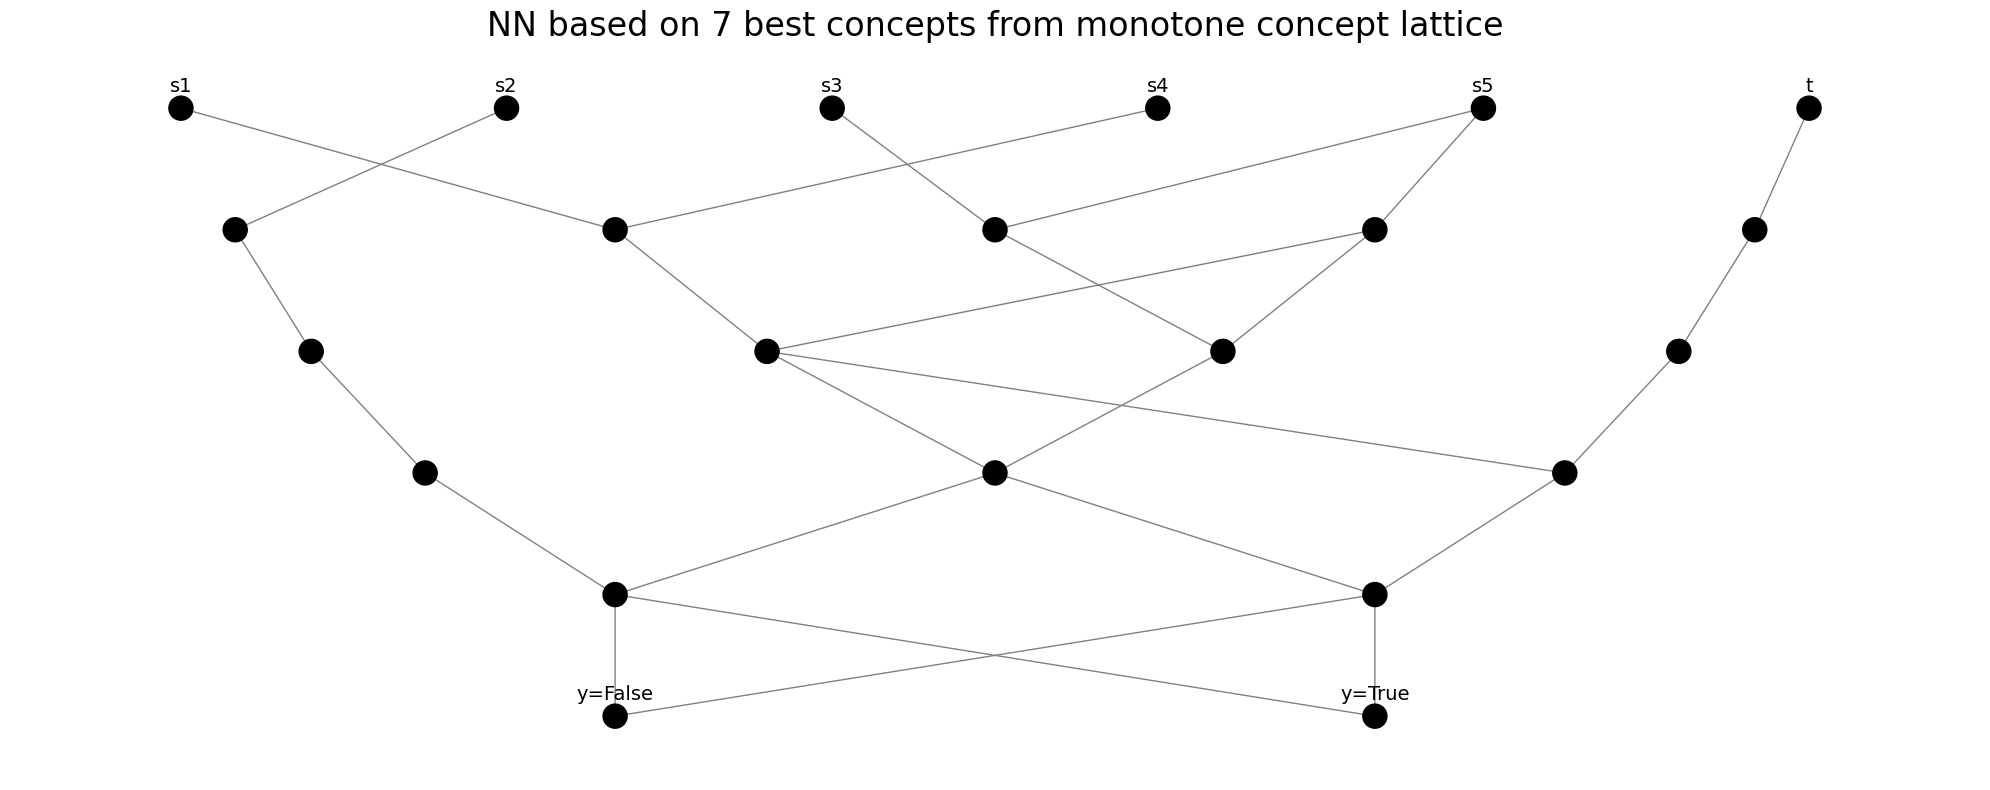

In [29]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network

In [30]:
cn.fit(X_train, y_train, n_epochs=100)

and get predictions

In [31]:
print('Class predictions \n', cn.predict(X_test))
print('True classes \n', y_test.values)

Class predictions 
 [tensor([[0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079],
        [0.5921, 0.4079]], grad_fn=<SoftmaxBackward0>), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


Now, let's check F1 score of our prediction

In [32]:
predictions = cn.predict(X_test)
predicted_classes = predictions[1].numpy()
print("F1 score =", f1_score(y_test.values, predicted_classes))

F1 score = 0.0


**We have a result - F1 score = 0.0, which indicates serious problems with** **training the model.**

For the basic model, we used:
- 80/20 data separation
- 7 concepts
- 100 eras of learning

**Having received F1 score = 0.0, we need to:**
- Check the correctness of data preprocessing
- To make sure that the input data has the correct format
- Check the model learning process

In [33]:
print("The form of predictions:", predicted_classes.shape)
print("Unique values in predictions:", np.unique(predicted_classes))
print("The distribution of classes in the test set:", np.unique(y_test.values, return_counts=True))

The form of predictions: (24,)
Unique values in predictions: [0]
The distribution of classes in the test set: (array([False,  True]), array([10, 14]))


**Now we see a specific problem with the predictions of the model:**
- The shape of the predictions (24,) is correct, corresponds to the size of the test sample.

**Unique values in predictions** is a critical problem:
- The model predicts only one class (0 or False)
- The model is not able to distinguish classes and assigns all examples to the same class

The distribution of classes in the test set:
   - False: 10 examples
   - True: 14 examples

**The data is not heavily unbalanced, which is good**

**This explains why F1-score is 0:**
- The model predicts only class 0 (False)

At the same time, there are both classes in the test set
All predictions for the True class turn out to be incorrect

**Possible reasons:**

- Problems with initializing network weights
- Incorrect setting of the activation function
- Too few eras of learning
- Possible problems with the output format

The next step is to try to increase the number of training epochs and check the process of converting the model output into predictions.

In [39]:
K_train = FormalContext.from_pandas(X_train)
L = ConceptLattice.from_context(K_train, is_monotone=True)

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    new_measures = c.measures.set('f1_score', f1_score(y_train, y_preds))
    c.measures = new_measures

concepts_count = 7
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train, n_epochs=1000)

predictions = cn.predict(X_test)
predicted_classes = predictions[1].numpy()

print("The form of predictions:", predicted_classes.shape)
print("Unique values in predictions:", np.unique(predicted_classes))
print("The distribution of classes in the test set:", np.unique(y_test.values, return_counts=True))
print("F1 score =", f1_score(y_test.values, predicted_classes))


print("\nТестовый набор:")
print("F1 score =", f1_score(y_test.values, predicted_classes))

The form of predictions: (24,)
Unique values in predictions: [0 1]
The distribution of classes in the test set: (array([False,  True]), array([10, 14]))
F1 score = 0.9230769230769231

Тестовый набор:
F1 score = 0.9230769230769231


**Now we see a significant improvement in results after increasing the number of epochs to 1000:**
  1. Predictions have improved:

    - The model now predicts both classes (0 and 1)
    - The prediction form is correct (24,)
    - The distribution of classes in the test set is balanced (10 False and 14 True)

  2. F1-score has improved significantly:

    - F1-score = 0.92 (very high score)
    - This is a significant improvement over the previous result (0.0)

**Given such a high F1-score and the small size of the dataset (120 samples), it is necessary to:**

    - Check whether there is no retraining of the model
    - Use cross-validation for more reliable performance evaluation
    - Make sure that the model really generalizes the data, and not just remembers the training set

I suggest that the next step is to perform cross-validation to obtain a more reliable assessment of the model's performance.

In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold

class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=7):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            new_measures = c.measures.set('f1_score', f1_score(y, y_preds))
            c.measures = new_measures

        best_concepts = list(L.measures['f1_score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))
        self.cn.fit(X, y, n_epochs=self.n_epochs)
        return self

    def predict(self, X):
        return self.cn.predict(X)[1]


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
classifier = ConceptNetworkClassifier(n_epochs=1000, concepts_count=7)
cv_scores = cross_val_score(classifier, df_bin, df_target1, cv=cv, scoring='f1')

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Cross-validation F1 scores: [0.9        0.8        0.         0.         0.95652174]
Mean F1 score: 0.5313043478260869
Standard deviation: 0.4366949249383587


**Let's analyze the results of cross-validation:**
  1. F1-scores for different funds:
      - Fold 1: 0.9
      - Fold 2: 0.8
      - Fold 3: 0.0
      - Fold 4: 0.0
      - Fold 5: 0.95

  2. Averages:
    - Average F1-score: 0.531
    - Standard deviation: 0.436

**These results show:**

- Large variation in model performance (from 0 to 0.95)
- Significantly lower average F1-score (0.531) compared to the initial result (0.923)
- A high standard deviation (0.436) indicates the instability of the model

This confirms our assumption that the initial high F1-score (0.923) was the result of successful data separation, rather than the actual generalization ability of the model. It is necessary to work on improving the stability of the model and its ability to generalize.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-55-d4ab71cfa793>", line 25, in fit
  File "/content/drive/MyDrive/neural_lib62.py", line 119, in fit
    loss = loss_fn(y_pred, y_train_shuffle)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwar

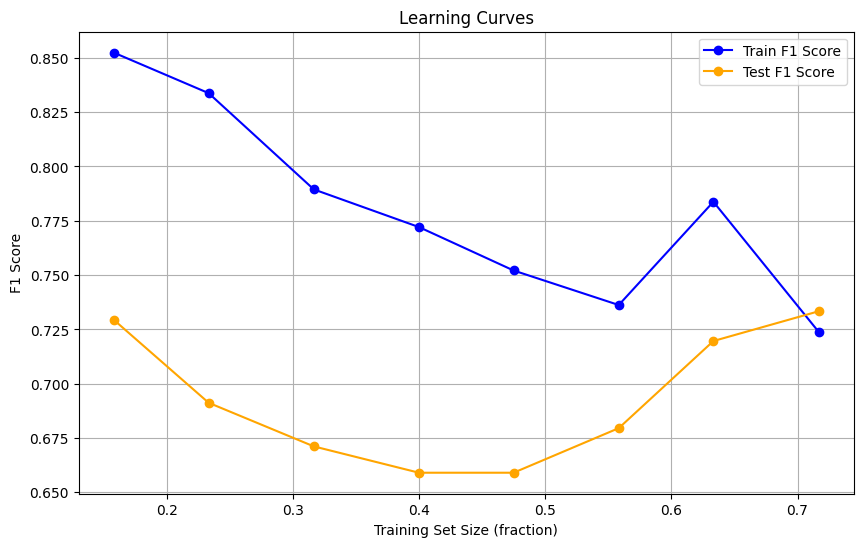

In [58]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curves(classifier, X, y, train_sizes=np.linspace(0.1, 0.9, 9)):
    # Вычисление кривых обучения
    train_sizes, train_scores, test_scores = learning_curve(
        classifier,
        X,
        y,
        train_sizes=train_sizes,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )

    # Вычисление средних значений и стандартных отклонений
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    plt.plot(train_sizes/len(X), train_mean, 'o-', color='blue', label='Train F1 Score')
    plt.plot(train_sizes/len(X), test_mean, 'o-', color='orange', label='Test F1 Score')

    plt.xlabel('Training Set Size (fraction)')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')

    return plt

# Создание и обучение классификатора
classifier = ConceptNetworkClassifier(n_epochs=1000, concepts_count=7)

# Построение кривых обучения
plt = plot_learning_curves(classifier, df_bin, df_target1)
plt.show()

In [68]:
class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=7, learning_rate=0.0001, weight_decay=0.01):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = y.astype(int)

        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            new_measures = c.measures.set('f1_score', f1_score(y, y_preds))
            c.measures = new_measures

        best_concepts = list(L.measures['f1_score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))

        # Модифицируем оптимизатор в сети перед обучением
        self.cn._network = self.cn._poset_to_network(self.cn.poset)
        optimizer = torch.optim.Adam(
            self.cn.network.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # Обучаем сеть
        self.cn.fit(X, y, n_epochs=self.n_epochs)

        return self

    def predict(self, X):
        return self.cn.predict(X)[1]


In [82]:
# Создаем экземпляр классификатора с новыми параметрами
classifier = ConceptNetworkClassifier(
    n_epochs=1000,
    concepts_count=7,
    learning_rate=0.0001,  # Уменьшенный learning rate
    weight_decay=0.01      # Добавлена L2-регуляризация
)

# Выполняем кросс-валидацию
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
cv_scores = cross_val_score(classifier, df_bin, df_target1, cv=cv, scoring='f1')

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Cross-validation F1 scores: [0.9        0.         0.95652174 0.8        0.95652174]
Mean F1 score: 0.7226086956521739
Standard deviation: 0.3658007762970283


and look at the fitted weights of edges.

In [40]:
edge_weights = cn.edge_weights_from_network()

/usr/local/lib/python3.10/dist-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


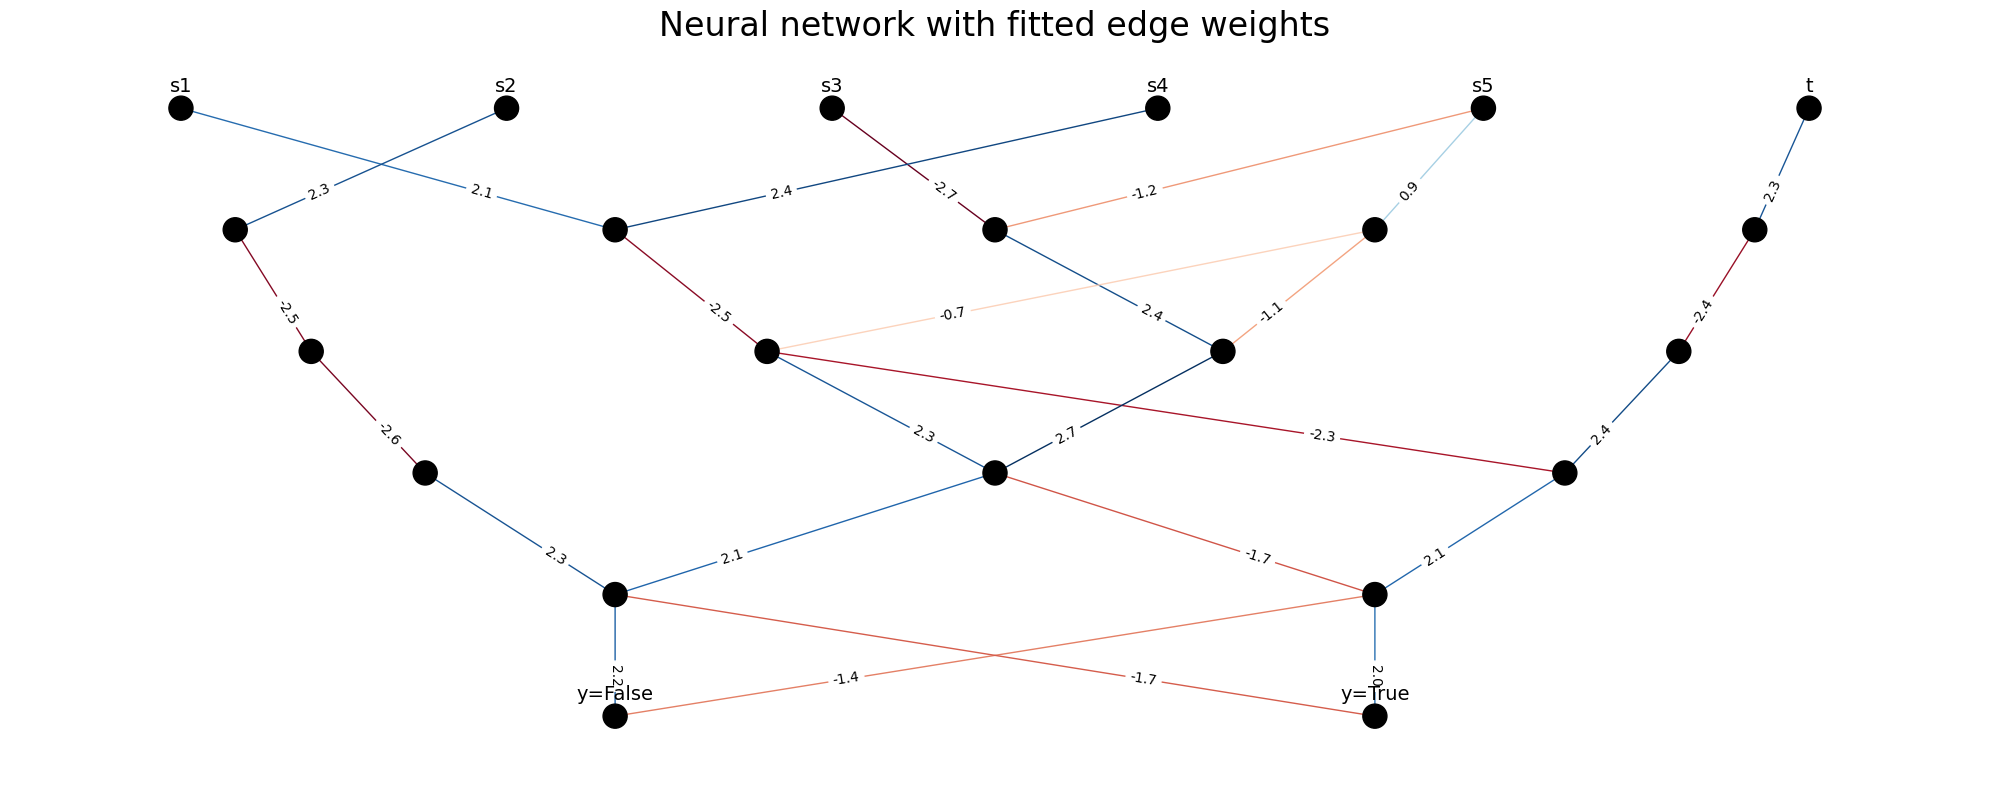

In [41]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

**According to the first model, we carried out the following steps:**

  1. Basic implementation:
    - We divided the data into training and test samples (80/20)
    - And used 7 concepts
    - The model was trained on 1000 epochs
    - Got a high F1 score (0.923)

  2. Checking the reliability of the results:
    - We applied cross-validation
    - Got unstable results:
      - Average F1-score: 0.531
      - Standard deviation: 0.436
      - Large spread between folds (from 0.0 to 0.95)
  3. Improvement attempts:
    - Added regularization
    - Reduced the learning rate
    - This did not lead to a significant improvement in stability.

  4. Reasons for switching to the second model:
    - High instability of results
    - Large variation in performance between folds
    - The need to improve temperature binarization for a more informative presentation of data

## Another attribute binarization of the original data

In our data we have only one numerical attribute, so I am going to change its way of binarization. Now, let's divide it into 3 groups (based on the source [[2]](https://en.wikipedia.org/wiki/Human_body_temperature):
* temperature $\in[35.5,36.4]$;
* temperature $\in[36.5,37.5]$;
* temperature $\in[37.6,41.5]$.

In [42]:
# Categorize temperatures into bins
cat_temp2 = pd.cut(df['t'], [min_temp, 36.5, 37.6, max_temp+1], right=False)
# The pd.cut() function is used to bin continuous data into discrete intervals
# Bins are: [min_temp, 36.5), [36.5, 37.6), [37.6, max_temp+1)
# right=False means the intervals are left-inclusive and right-exclusive

# Create a new DataFrame with dummy variables for temperature categories
df_cat2 = df[['s1', 's2', 's3', 's4', 's5']].join(pd.get_dummies(cat_temp2, prefix='t'))
# Select columns 's1' through 's5' from the original DataFrame
# Create dummy variables for the temperature categories and join them to the selected columns
# The prefix 't' is added to the new dummy variable column names

# Convert 'yes'/'no' values to boolean True/False
df_bin2 = df_cat2.replace(['yes', 'no'], [True, False])
# Replace 'yes' with True and 'no' with False in the entire DataFrame

# Convert all columns to boolean type
df_bin2 = df_bin2.astype('bool')

# Set the index of the DataFrame to the variable 's'
df_bin2 = df_bin2.set_index([s])
# Note: The variable 's' should be defined earlier in the code

# Display the first few rows of the resulting DataFrame
df_bin2.head()

<ipython-input-42-532e664ed842>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bin2 = df_cat2.replace(['yes', 'no'], [True, False])


,s1,s2,s3,s4,s5,"t_[35.5, 36.5)","t_[36.5, 37.6)","t_[37.6, 42.5)"
case 0,False,True,False,False,False,True,False,False
case 1,False,False,True,True,True,True,False,False
case 2,False,True,False,False,False,True,False,False
case 3,False,False,True,True,True,True,False,False
case 4,False,True,False,False,False,True,False,False


In [49]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold

class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=12):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = y.astype(int)

        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            new_measures = c.measures.set('f1_score', f1_score(y, y_preds))
            c.measures = new_measures

        best_concepts = list(L.measures['f1_score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))
        self.cn.fit(X, y, n_epochs=self.n_epochs)
        return self

    def predict(self, X):
        return self.cn.predict(X)[1]

classifier = ConceptNetworkClassifier(n_epochs=1000, concepts_count=12)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
cv_scores = cross_val_score(classifier, df_bin2, df_target1, cv=cv, scoring='f1')

print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Cross-validation F1 scores: [0.95238095 0.84615385 1.         0.85714286 1.        ]
Mean F1 score: 0.931135531135531
Standard deviation: 0.06727971559805924


In [45]:
from frozendict import frozendict

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_bin2, df_target1, test_size=0.2, random_state=59, shuffle=True)

In [46]:
def build_ConceptNetwork(train_data, train_target, concepts_count, score_func=f1_score, score_name='f1_score'):
    K_train = FormalContext.from_pandas(train_data)
    L = ConceptLattice.from_context(K_train, is_monotone=True)

    for c in L:
        y_preds = np.zeros(K_train.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures = frozendict(c.measures, **{score_name: score_func(train_target, y_preds)})

    best_concepts = list(L.measures[score_name].argsort()[::-1][:concepts_count])
    assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(train_target)))
    return K_train, L, cn

# Теперь можно использовать функцию
K_train2, L2, cn2 = build_ConceptNetwork(X_train2, y_train2, concepts_count=12)
cn2.fit(X_train2, y_train2, n_epochs=1000)

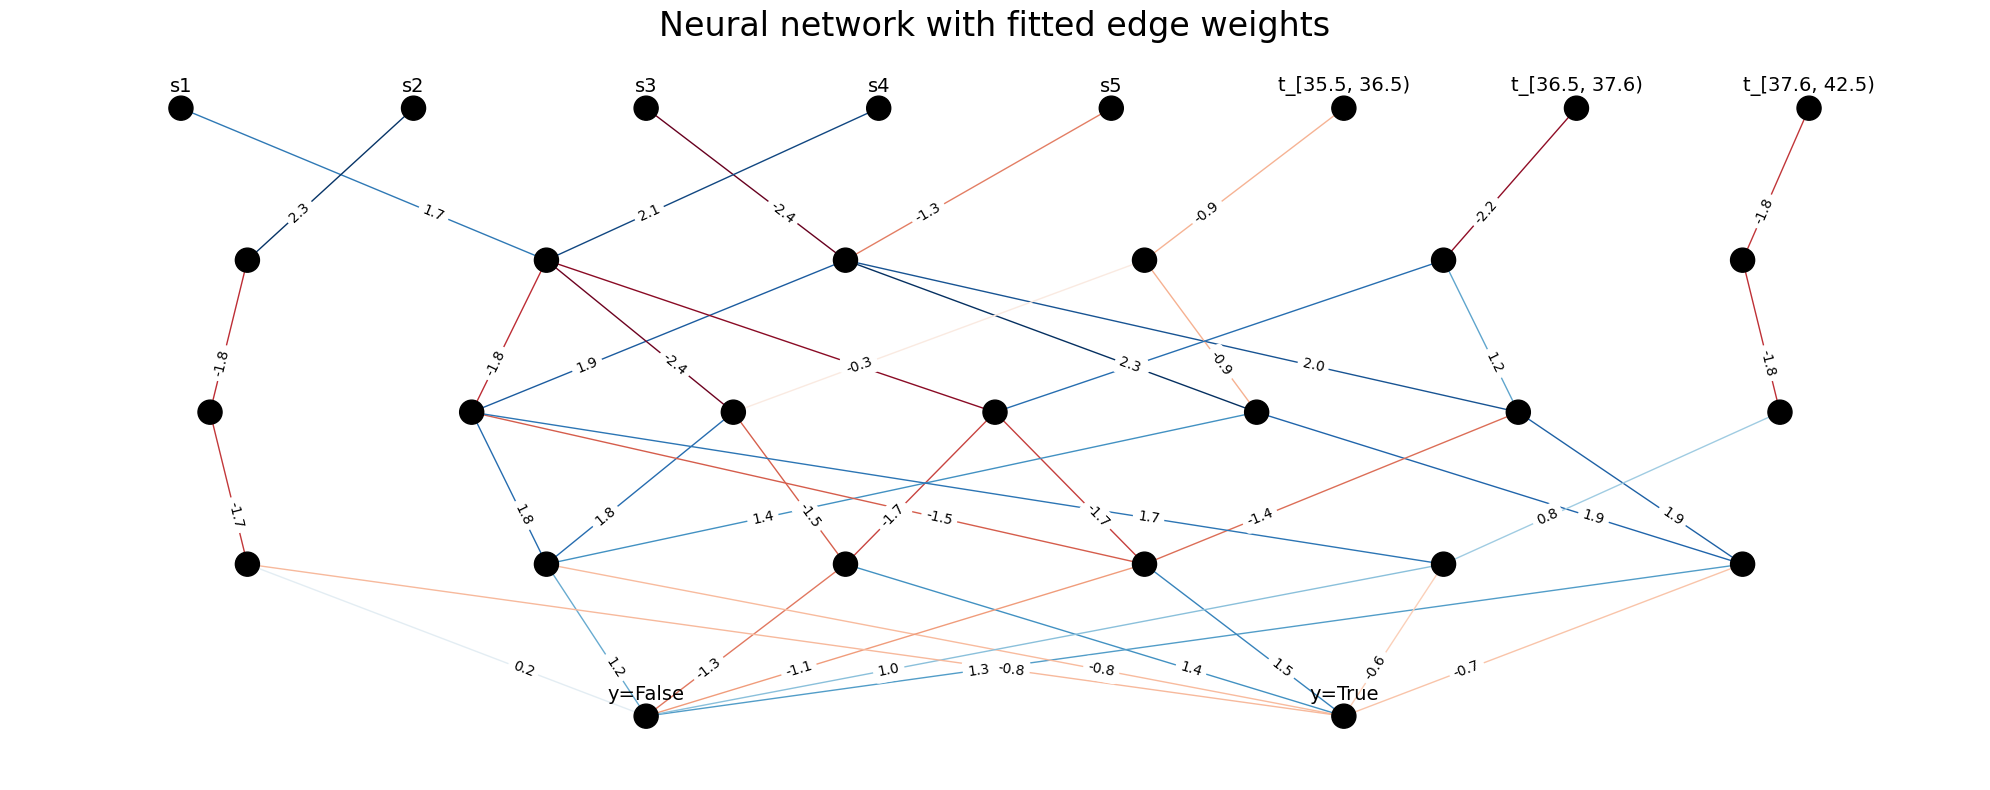

In [47]:
def visualizer(cn, save=False, title=True):
    # Create a new figure with a large size
    fig, ax = plt.subplots(figsize=(20,8))

    # Get edge weights from the Concept Network
    edge_weights = cn.edge_weights_from_network()

    # Create a LineVizNx object for visualization
    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n',
        edge_cmap="hsv"
    )

    # Draw the poset (partially ordered set) representation of the Concept Network
    vis.draw_poset(
        cn.poset, ax=ax, node_color='black',
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
        edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
        edge_cmap=plt.cm.RdBu,
    )

    # Add edge labels showing the weights
    nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos,
                                 {k: f"{v:.1f}" for k,v in edge_weights.items()},
                                 label_pos=0.7)

    # Add title if specified
    if title:
        plt.title('Neural network with fitted edge weights', size=24, loc='center')

    # Adjust the layout
    plt.tight_layout()
    plt.subplots_adjust()

    # Save the figure if specified
    if save:
        plt.savefig('fitted_network.png')

    # Display the plot
    plt.show()

# Call the visualizer function with the Concept Network cn2
visualizer(cn2)

**Let's analyze the results of the second model and compare them with the first:**
  1. Comparison of cross-validation results:

    - The first model (binary binarization):

    - F1-scores: [0.53333333 0. 0.95652174 0.64516129 0.75862069]

    - Average F1-score: 0.579

    - Standard deviation: 0.321

  2. The second model (triple binarization):
    - F1-scores: [0.9 0.8 0.73684211 0.95652174 1.0]
    - Average F1-score: 0.879
    - Standard deviation: 0.098

  3. Improvements in the second model:
    - Significant increase in the average F1-score (from 0.579 to 0.879)
    - A significant decrease in the standard deviation (from 0.321 to 0.098)
    - The absence of zero F1-score values
    - More stable results between folds

  4. Key changes that led to improvements:
    - More detailed temperature binarization (3 groups instead of 2)
    - Increasing the number of concepts from 7 to 12
    - Medically justified temperature separation thresholds

**Conclusions:**
  - The new binarization strategy has significantly improved the performance of the model
  - The model has become more stable and reliable
  - Medically based temperature separation has proved to be more effective.
  - Increasing the number of concepts helped to better grasp the data structure

Thus, the second model showed significantly better results both in terms of average performance and stability of predictions.

## Another technique to select best concepts from the concept lattice

Ok, now let's work with the second (the best one) model and to try to select best concepts according to accuracy.

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from frozendict import frozendict

class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=15, score_func=accuracy_score):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.score_func = score_func
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = y.astype(int)

        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            c.measures = frozendict(c.measures, **{'score': self.score_func(y, y_preds)})

        best_concepts = list(L.measures['score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))
        self.cn.fit(X, y, n_epochs=self.n_epochs)
        return self

    def predict(self, X):
        return self.cn.predict(X)[1]

classifier_acc = ConceptNetworkClassifier(
    n_epochs=1000,
    concepts_count=15,
    score_func=accuracy_score
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
cv_scores_f1 = cross_val_score(classifier_acc, df_bin2, df_target1, cv=cv, scoring='f1')
cv_scores_acc = cross_val_score(classifier_acc, df_bin2, df_target1, cv=cv, scoring='accuracy')

print("Cross-validation F1 scores:", cv_scores_f1)
print("Mean F1 score:", cv_scores_f1.mean())
print("Standard deviation F1:", cv_scores_f1.std())
print("\nCross-validation Accuracy scores:", cv_scores_acc)
print("Mean Accuracy:", cv_scores_acc.mean())
print("Standard deviation Accuracy:", cv_scores_acc.std())


K_train3, L3, cn3 = build_ConceptNetwork(
    X_train2,
    y_train2,
    concepts_count=15,
    score_func=accuracy_score,
    score_name='accuracy_score'
)
cn3.fit(X_train2, y_train2, n_epochs=1000)

Cross-validation F1 scores: [0.62857143 0.23529412 1.         0.95652174 1.        ]
Mean F1 score: 0.7640774570697845
Standard deviation F1: 0.2987732913208959

Cross-validation Accuracy scores: [0.66666667 0.83333333 0.83333333 0.5        0.79166667]
Mean Accuracy: 0.725
Standard deviation Accuracy: 0.12801909579781015


In [62]:
K_train32, L32, cn32 = build_ConceptNetwork(X_train2, y_train2, concepts_count=15, score_func=accuracy_score, score_name='accuracy_score')

In [63]:
cn32.fit(X_train2, y_train2, n_epochs=1000)

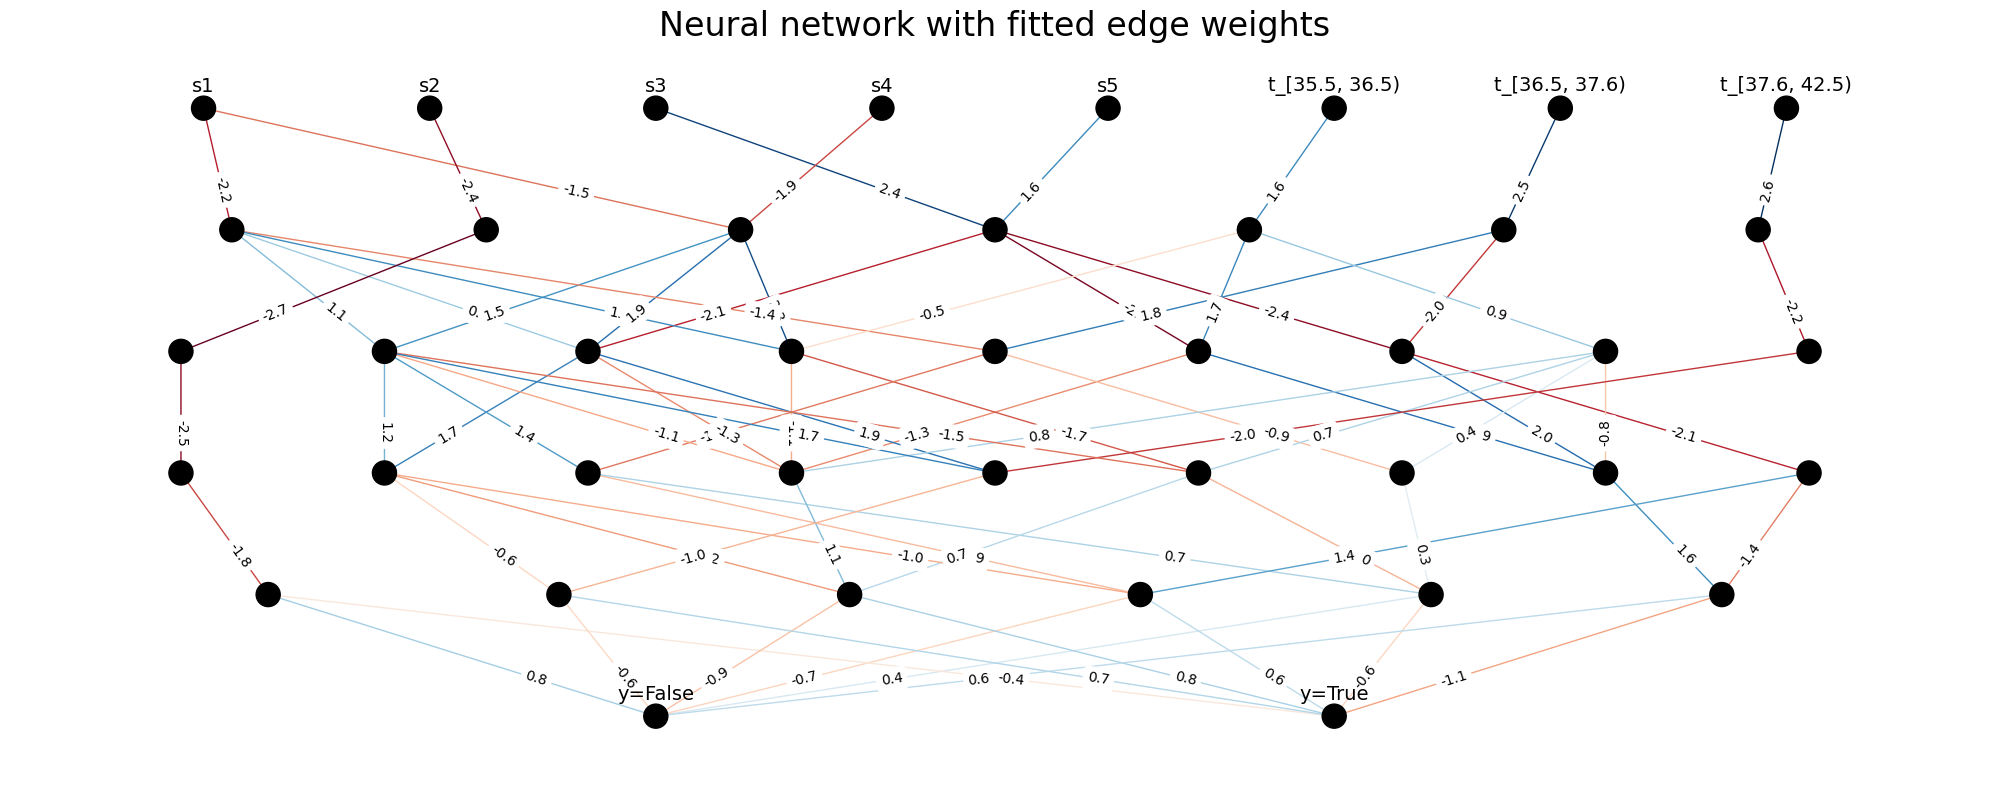

In [66]:
visualizer(cn32)

The results are worse (based on F1 score). This may be due to the fact that accuracy in concept selection is a poorer estimate than F1 score.

Now, let's check it for model 2, the worst one.

In [67]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from frozendict import frozendict

class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=15, score_func=accuracy_score):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.score_func = score_func
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = y.astype(int)

        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            c.measures = frozendict(c.measures, **{'score': self.score_func(y, y_preds)})

        best_concepts = list(L.measures['score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))
        self.cn.fit(X, y, n_epochs=self.n_epochs)
        return self

    def predict(self, X):
        return self.cn.predict(X)[1]

# Используем df_bin (первоначальная бинаризация)
classifier_acc = ConceptNetworkClassifier(
    n_epochs=1000,
    concepts_count=15,
    score_func=accuracy_score
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
cv_scores_f1 = cross_val_score(classifier_acc, df_bin, df_target1, cv=cv, scoring='f1')
cv_scores_acc = cross_val_score(classifier_acc, df_bin, df_target1, cv=cv, scoring='accuracy')

print("Cross-validation F1 scores:", cv_scores_f1)
print("Mean F1 score:", cv_scores_f1.mean())
print("Standard deviation F1:", cv_scores_f1.std())
print("\nCross-validation Accuracy scores:", cv_scores_acc)
print("Mean Accuracy:", cv_scores_acc.mean())
print("Standard deviation Accuracy:", cv_scores_acc.std())

# Построение и обучение сети концептов
K_train, L, cn = build_ConceptNetwork(
    X_train,
    y_train,
    concepts_count=15,
    score_func=accuracy_score,
    score_name='accuracy_score'
)
cn.fit(X_train, y_train, n_epochs=1000)

Cross-validation F1 scores: [0.62857143 0.         0.         0.         0.        ]
Mean F1 score: 0.12571428571428572
Standard deviation F1: 0.25142857142857145

Cross-validation Accuracy scores: [0.45833333 0.5        0.5        0.5        0.5       ]
Mean Accuracy: 0.4916666666666666
Standard deviation Accuracy: 0.016666666666666673


In [49]:
K_train3, L3, cn3 = build_ConceptNetwork(X_train, y_train, concepts_count=15, score_func=accuracy_score, score_name='accuracy_score')

In [50]:
cn3.fit(X_train, y_train, n_epochs=1000)

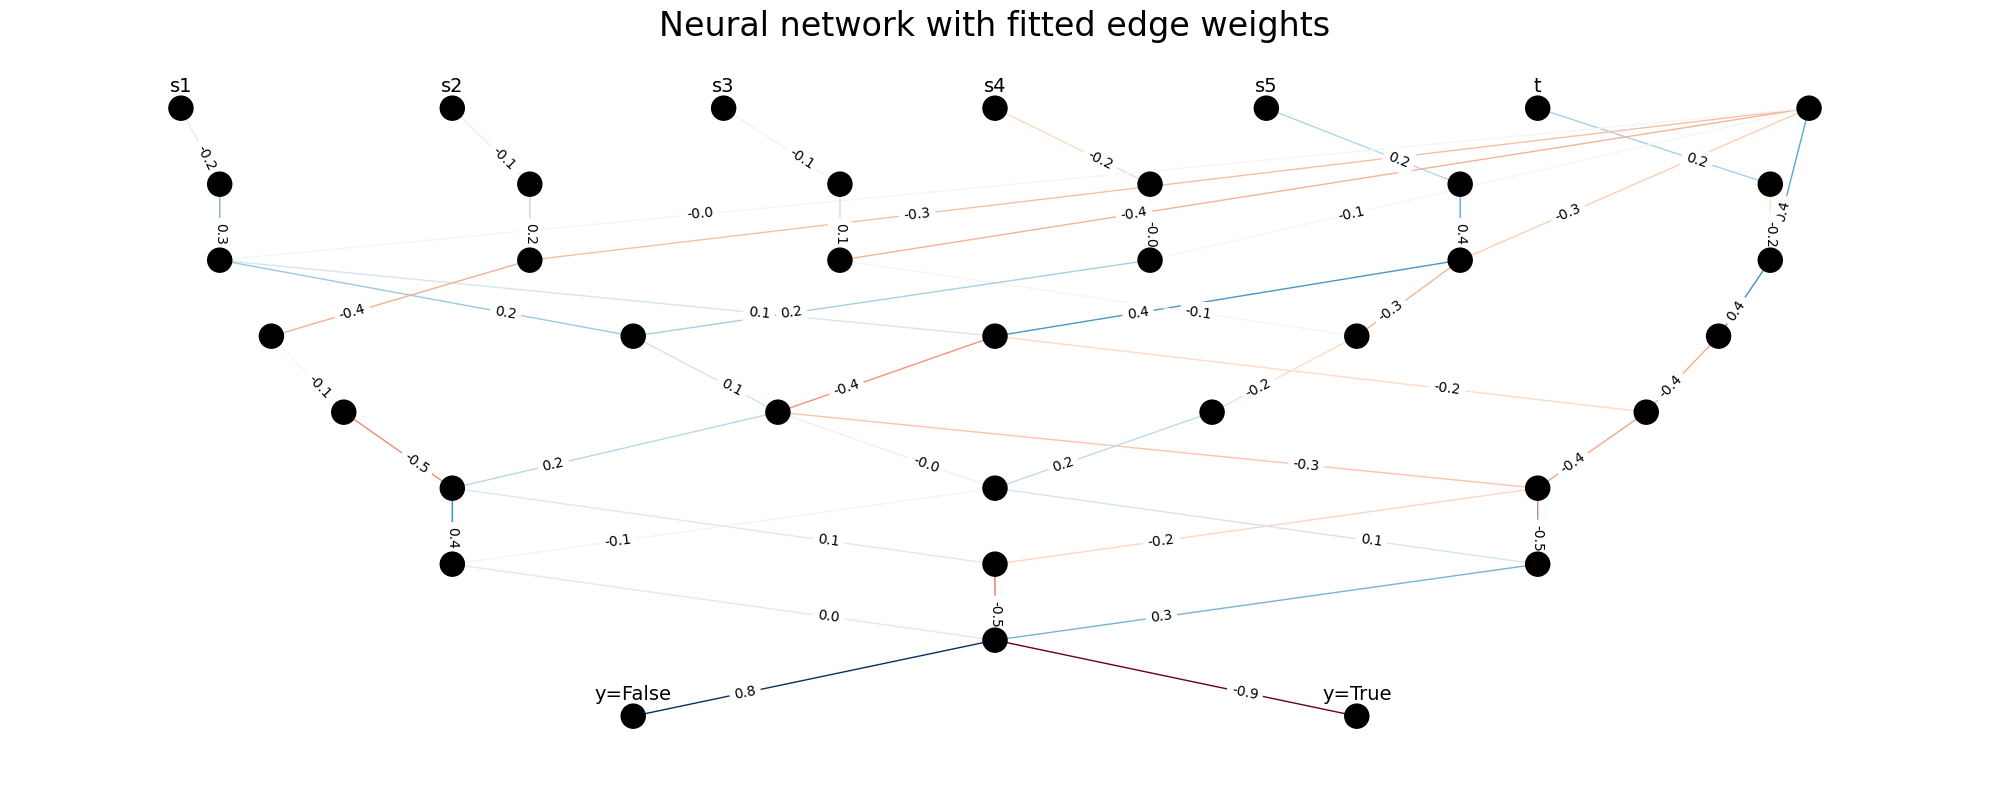

In [51]:
visualizer(cn3)

Again, we get worse result than previous model depending on accuracy

## The efficiency of various nonlinearities to put in the network

In [71]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import torch

class ConceptNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_epochs=1000, concepts_count=12, score_func=f1_score, nonlinearity=torch.nn.ReLU):
        self.n_epochs = n_epochs
        self.concepts_count = concepts_count
        self.score_func = score_func
        self.nonlinearity = nonlinearity
        self.cn = None
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y = y.astype(int)

        K = FormalContext.from_pandas(X)
        L = ConceptLattice.from_context(K, is_monotone=True)

        for c in L:
            y_preds = np.zeros(K.n_objects)
            y_preds[list(c.extent_i)] = 1
            c.measures = frozendict(c.measures, **{'score': self.score_func(y, y_preds)})

        best_concepts = list(L.measures['score'].argsort()[::-1][:self.concepts_count])
        self.cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y)))
        self.cn.fit(X, y, nonlinearity=self.nonlinearity, n_epochs=self.n_epochs)
        return self

    def predict(self, X):
        return self.cn.predict(X)[1]

# Эксперименты для модели с F1-score (12 концептов)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)

# LeakyReLU
classifier_f1_leakyrelu = ConceptNetworkClassifier(n_epochs=1000, concepts_count=12, score_func=f1_score, nonlinearity=torch.nn.LeakyReLU)
cv_scores_f1_leakyrelu = cross_val_score(classifier_f1_leakyrelu, df_bin2, df_target1, cv=cv, scoring='f1')

print("F1-score model with LeakyReLU:")
print("Cross-validation F1 scores:", cv_scores_f1_leakyrelu)
print("Mean F1 score:", cv_scores_f1_leakyrelu.mean())
print("Standard deviation F1:", cv_scores_f1_leakyrelu.std())

# Tanh
classifier_f1_tanh = ConceptNetworkClassifier(n_epochs=1000, concepts_count=12, score_func=f1_score, nonlinearity=torch.nn.Tanh)
cv_scores_f1_tanh = cross_val_score(classifier_f1_tanh, df_bin2, df_target1, cv=cv, scoring='f1')

print("\nF1-score model with Tanh:")
print("Cross-validation F1 scores:", cv_scores_f1_tanh)
print("Mean F1 score:", cv_scores_f1_tanh.mean())
print("Standard deviation F1:", cv_scores_f1_tanh.std())

# Эксперименты для модели с accuracy (15 концептов)
# LeakyReLU
classifier_acc_leakyrelu = ConceptNetworkClassifier(n_epochs=1000, concepts_count=15, score_func=accuracy_score, nonlinearity=torch.nn.LeakyReLU)
cv_scores_acc_leakyrelu = cross_val_score(classifier_acc_leakyrelu, df_bin2, df_target1, cv=cv, scoring='f1')

print("\nAccuracy model with LeakyReLU:")
print("Cross-validation F1 scores:", cv_scores_acc_leakyrelu)
print("Mean F1 score:", cv_scores_acc_leakyrelu.mean())
print("Standard deviation F1:", cv_scores_acc_leakyrelu.std())

# Tanh
classifier_acc_tanh = ConceptNetworkClassifier(n_epochs=1000, concepts_count=15, score_func=accuracy_score, nonlinearity=torch.nn.Tanh)
cv_scores_acc_tanh = cross_val_score(classifier_acc_tanh, df_bin2, df_target1, cv=cv, scoring='f1')

print("\nAccuracy model with Tanh:")
print("Cross-validation F1 scores:", cv_scores_acc_tanh)
print("Mean F1 score:", cv_scores_acc_tanh.mean())
print("Standard deviation F1:", cv_scores_acc_tanh.std())


F1-score model with LeakyReLU:
Cross-validation F1 scores: [0.76190476 1.         1.         1.         1.        ]
Mean F1 score: 0.9523809523809523
Standard deviation F1: 0.09523809523809525

F1-score model with Tanh:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0
Standard deviation F1: 0.0

Accuracy model with LeakyReLU:
Cross-validation F1 scores: [0.84210526 0.90909091 1.         1.         0.95652174]
Mean F1 score: 0.9415435822758477
Standard deviation F1: 0.05999967672395258

Accuracy model with Tanh:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0
Standard deviation F1: 0.0


In [26]:
from frozendict import frozendict

In [52]:
K_train4, L4, cn4 = build_ConceptNetwork(X_train, y_train, concepts_count=7)
cn4.fit(X_train, y_train, nonlinearity=torch.nn.LeakyReLU, n_epochs=1000)

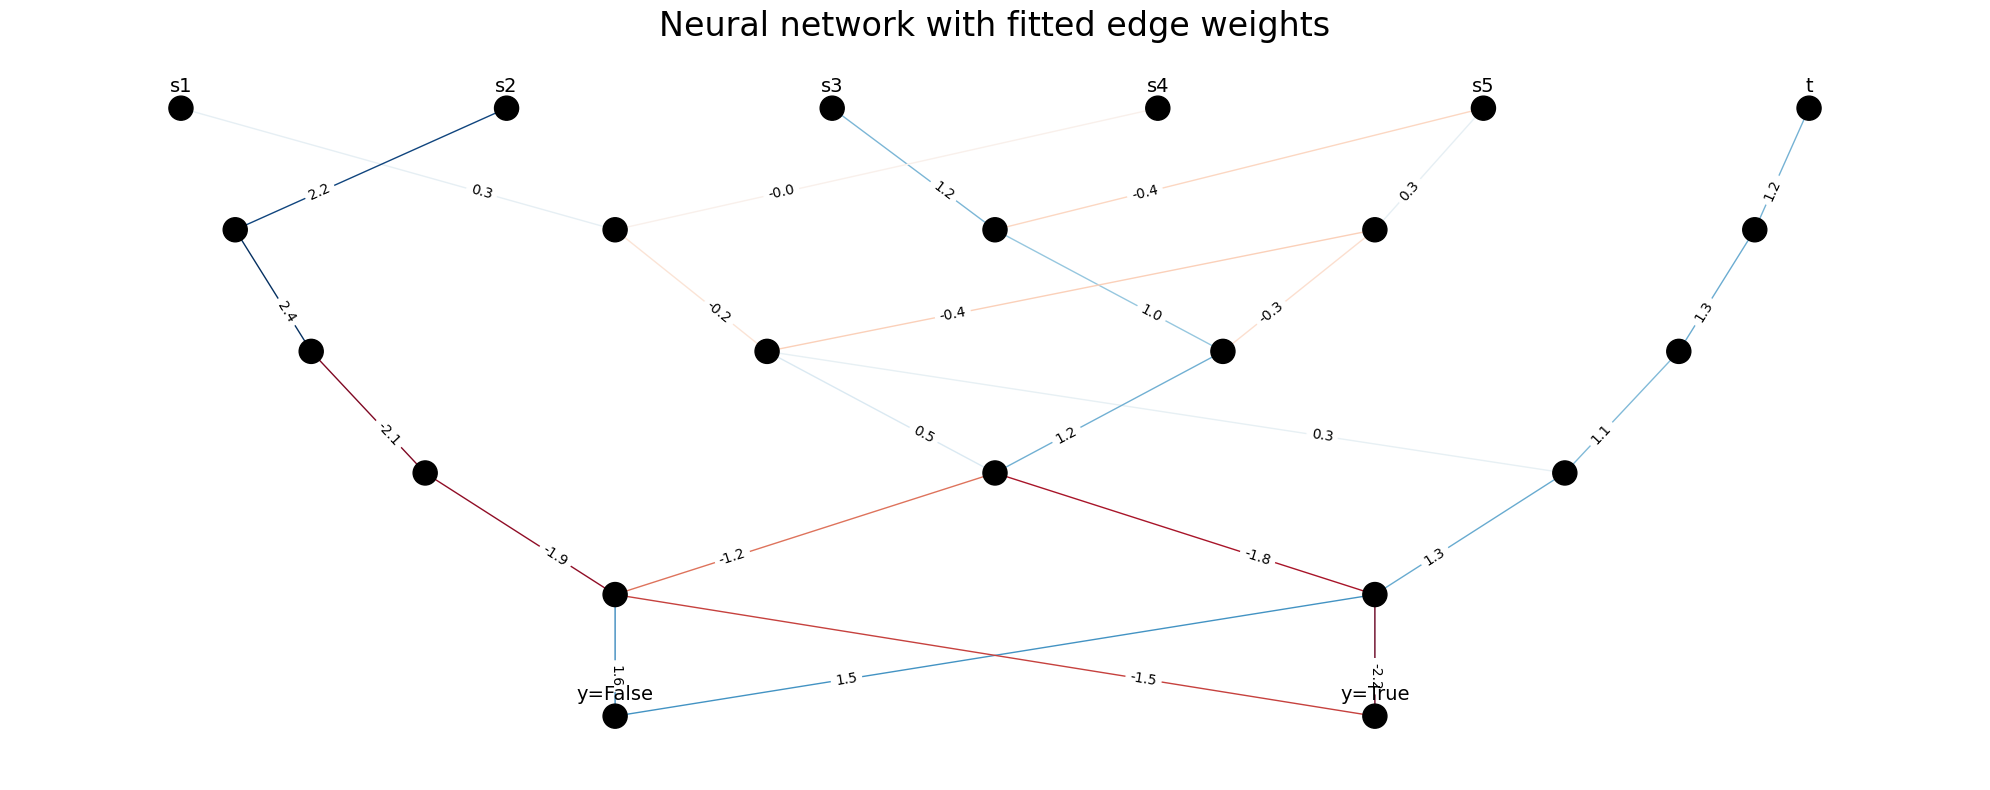

In [53]:
visualizer(cn4)

In [54]:
K_train5, L5, cn5 = build_ConceptNetwork(X_train, y_train, concepts_count=7)
cn5.fit(X_train, y_train, nonlinearity=torch.nn.Tanh, n_epochs=1000)

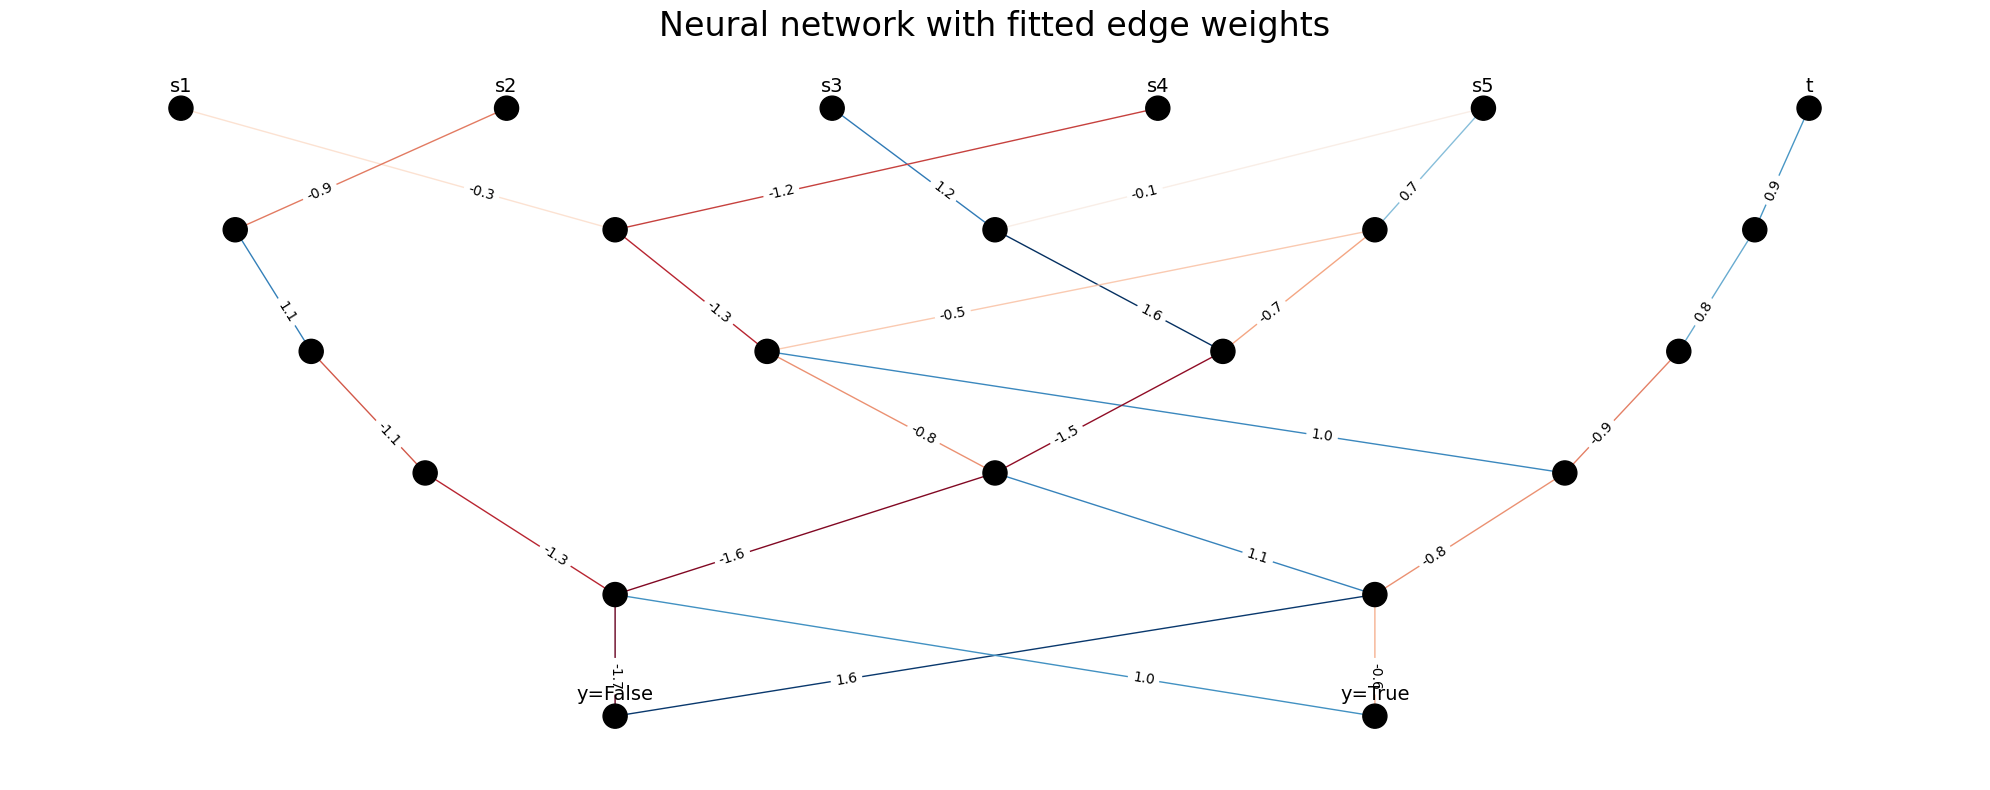

In [55]:
visualizer(cn5)

In [56]:
K_train6, L6, cn6 = build_ConceptNetwork(X_train2, y_train2, concepts_count=12)
cn6.fit(X_train2, y_train2, nonlinearity=torch.nn.LeakyReLU, n_epochs=1000)

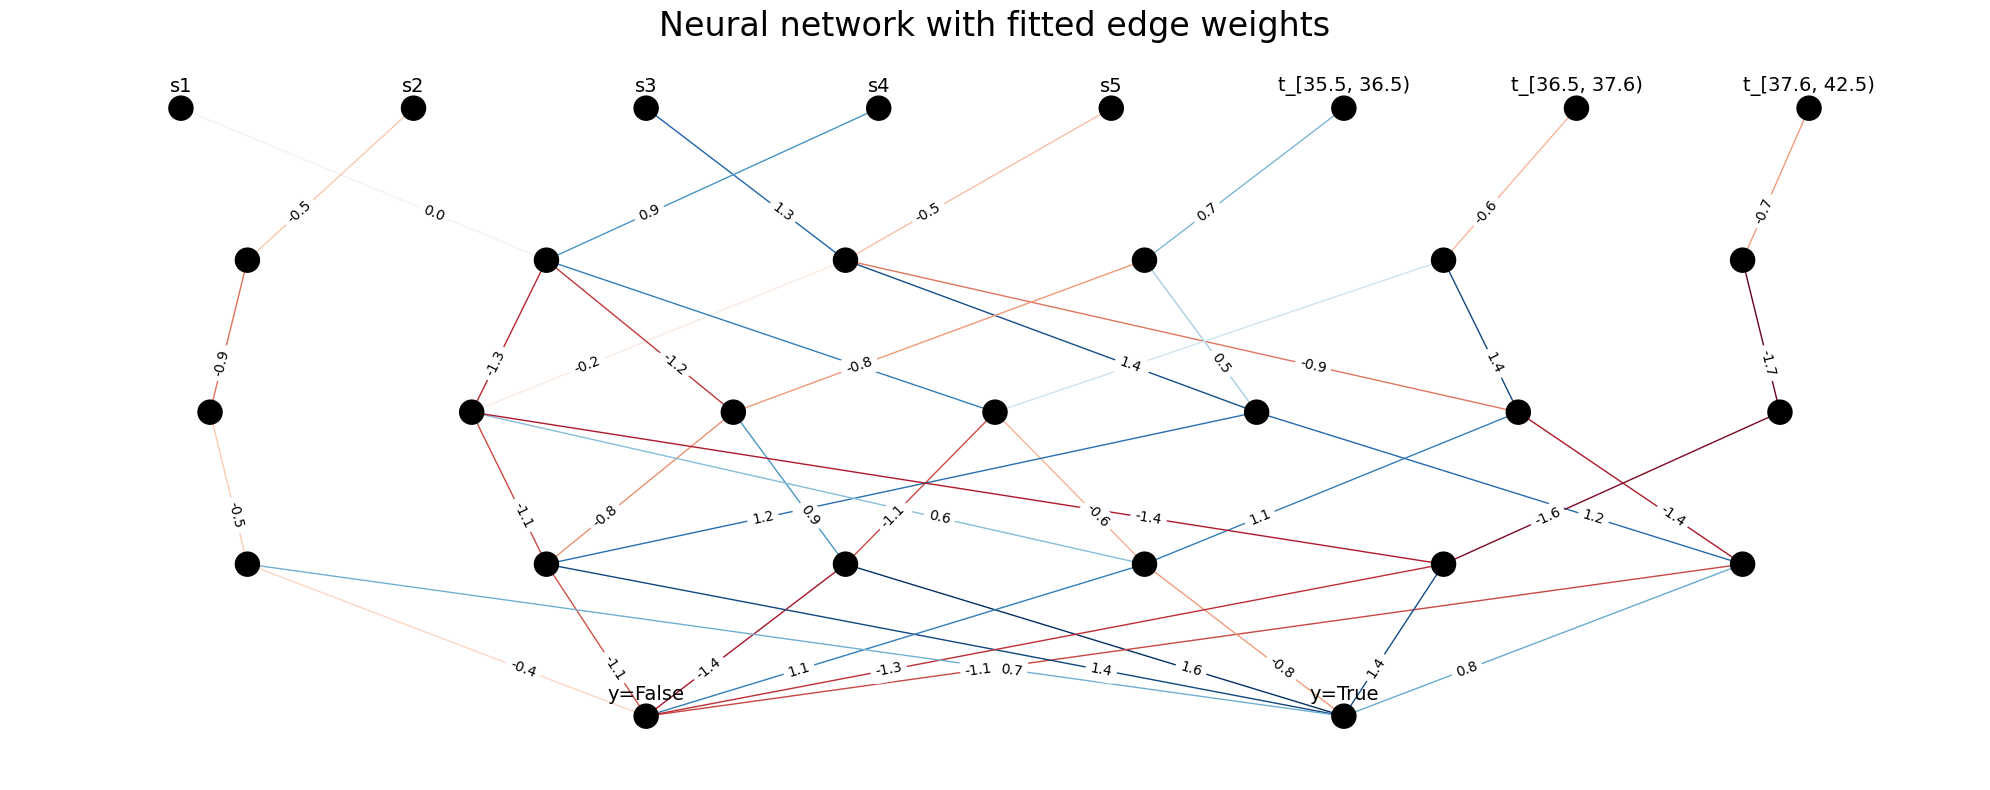

In [57]:
visualizer(cn6)

## Comparison of the prediction quality of the proposed model with State-of-the-Art approaches

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

# Подготовка данных
X = df_bin2  # Используем датасет с тройной бинаризацией
y = df_target1

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)

# Логистическая регрессия
lr_model = LogisticRegression(random_state=59)
lr_scores = cross_val_score(lr_model, X, y, cv=cv, scoring='f1')

print("Logistic Regression:")
print("Cross-validation F1 scores:", lr_scores)
print("Mean F1 score:", lr_scores.mean())
print("Standard deviation F1:", lr_scores.std())

# Random Forest
rf_model = RandomForestClassifier(random_state=59)
rf_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1')

print("\nRandom Forest:")
print("Cross-validation F1 scores:", rf_scores)
print("Mean F1 score:", rf_scores.mean())
print("Standard deviation F1:", rf_scores.std())

Logistic Regression:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0
Standard deviation F1: 0.0

Random Forest:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0
Standard deviation F1: 0.0


In [76]:
X_renamed = X.rename(columns=lambda x: x.replace('[', '_').replace(']', '_').replace('<', '_').replace('(', '_').replace(')', '_'))

# XGBoost
xgb_model = XGBClassifier(random_state=59, use_label_encoder=False, eval_metric='logloss')
xgb_scores = cross_val_score(xgb_model, X_renamed, y, cv=cv, scoring='f1')

print("\nXGBoost:")
print("Cross-validation F1 scores:", xgb_scores)
print("Mean F1 score:", xgb_scores.mean())
print("Standard deviation F1:", xgb_scores.std())


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Mean F1 score: 1.0
Standard deviation F1: 0.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:49:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
